<a href="https://colab.research.google.com/github/Mayanksince2003/disaster-detection-nlp/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying a piece of text as Disaster or Non Disaster

## Necessary Imports

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

## Getting Helper Functions for proper Plotting or results

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2025-04-19 12:32:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2025-04-19 12:32:48 (99.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



## Getting the data

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip the data
unzip_data("nlp_getting_started.zip")

--2025-04-19 12:32:48--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.101.207, 142.251.2.207, 142.250.141.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.101.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2025-04-19 12:32:48 (145 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Importing and Visualising the data

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Labels -> 1 means text is disaster and 0 means its not

In [ ]:
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
train_df.target.value_counts()

,count
target,
0,4342
1,3271


### Since labels are nearly equal, there is no need of upscaling or making them equal

In [ ]:
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# let's visualise some random training examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples():
  _, text, target = row
  print(text)
  print(f"Target: {target}", "real disaster" if target==1 else "not real disaster")
  print("_____________________________ \n")

will there be another jocelyn birthday apocalypse
Target: 0 not real disaster
_____________________________ 

Hellfire Gargoyle Hoof coil http://t.co/2ii3Brc7NX
Target: 0 not real disaster
_____________________________ 

How to Remove Softenza Hijacker? Softenza Anthelmintic Nature book Drawing out Help SEA
Target: 0 not real disaster
_____________________________ 

@kshllcenterpri1 @Progress4Ohio burning down buildings what you mean like when you burnt down those black churches?
Target: 1 real disaster
_____________________________ 

@allen_enbot If you mess up it's gonna explode...
Target: 1 real disaster
_____________________________ 



## Let's do the train test split

In [ ]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.2,
                                                                            random_state=42)

In [ ]:
train_sentences[:10], train_labels[:10]

(array(['#ModiMinistry Railway Minister Prabhu calls MP derailment a natural calamity http://t.co/tL41olpAkZ',
        "Did this man just squeeze another man's head with his bare hands until it literally exploded ???????",
        'Some drugs and alcohol in Jackson Vroman house.\n\nhttp://t.co/5OQhQ8QUQV',
        '@danagould @WaynesterAtl I agree with background checks. I just think guns or weapons in general are the great equalizer.',
        'you know you hate your body when you buy 2 bags of chips and a variety pack of fruit snacks and a redbull as a snack',
        'Pharma overloaded with a loud cry like an emergency siren. \n\n...fucking.',
        'I liked a @YouTube video from @sqwizzix http://t.co/GGqCz9AB6u Call of Duty: \x89ÛÏThe Piano Entertainer\x89Û\x9d Ep. 9 \x89ÛÒ Musicians Collide!',
        "@DDNewsLive @NitishKumar  and @ArvindKejriwal can't survive without referring @@narendramodi . Without Mr Modi they are BIG ZEROS",
        '#MakeWaterWork Okanagan! Drought ratin

In [ ]:
val_sentences[:10], val_labels[:10]

(array(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
        'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
        'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
        '@camilacabello97 Internally and externally screaming',
        'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov',
        'Investigators rule catastrophic structural failure resulted in 2014 Virg.. Related Articles: http://t.co/Cy1LFeNyV8',
        'How the West was burned: Thousands of wildfires ablaze in #California alone http://t.co/iCSjGZ9tE1 #climate #energy http://t.co/9FxmN0l0Bd',
        "Map: Typhoon Soudelor's predicted path as it approaches Taiwan; expected to make landfall over so

## Doing tokenization and embeddings

This Layer helps to convert the words into numbers so that any deep learing model or neural network can identify them easily, as well as it is easy to standardize and normalize them.
* it does
* Lowercasify everything
* remove punctuation
* tokenization
* build a vocab
* map words/tokens to integers
* pad or truncate the output

Embedding is for understanding of words by model, similar meaning words will have closer embeddings so that they can easily be uderstood by model.
This is an array of numbers.

In [ ]:
text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=10000, # Max unique tokens in vocabulary
                                                    standardize="lower_and_strip_punctuation", # As it looks
                                                    split="whitespace", # Tokenize at spaces
                                                    ngrams=2, # Makes two worded token e.g. "New York"
                                                    output_mode="int",
                                                    output_sequence_length=None, # length of each sentence after tokenization and embeddings
                                                    pad_to_max_tokens=True) # If length is less then pad or remove if length is higher than output seq length

In [ ]:
# Find average number of tokens in training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences)) # Means Each text has 15 tokens on average

15

In [ ]:
# Set up text vectorization vairables
max_vocab_length = 15000
max_length = 30

text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
                                                    standardize="lower_and_strip_punctuation", # As it looks
                                                    split="whitespace", # Tokenize at spaces
                                                    ngrams=3, # Makes two worded token e.g. "New York",
                                                  output_mode="int",
                                                  output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the train test
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "Hey there this is for NLP lab project"
text_vectorizer([sample_sentence]) # Padded with 0s for 15 tokens

<tf.Tensor: shape=(1, 30), dtype=int64, numpy=
array([[  689,    76,    19,     9,    10,     1,  1352,  4968, 14287,
            1,   228,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     0,     0,     0,     0,     0,     0,
            0,     0,     0]])>

In [ ]:
# Choose a random sentence from training data
random_sentence = random.choice(train_sentences)
print(f"Original Sentence ->\n{random_sentence}\n\nVectorized version -> ")
text_vectorizer(random_sentence)

Original Sentence ->
Any lengths to rescue a cat in need! http://t.co/AMroX4Y4Nx

Vectorized version -> 


<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([  209,     1,     5,   440,     3,  2177,     4,   214,     1,
           1,     1,     1,     1,     1,     1, 13826,     1,     1,
           1,     1,     1,     1,     1,     1,     0,     0,     0,
           0,     0,     0])>

In [ ]:
# get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 15000
Top 5 most common words: ['', '[UNK]', np.str_('the'), np.str_('a'), np.str_('in')]
Bottom 5 least common words: [np.str_('fight wild fires'), np.str_('fight wild'), np.str_('fight nuclear industry'), np.str_('fight nuclear'), np.str_('fifty online dates')]


## Create an Embedding layer
Embedding is for understanding of words by model, similar meaning words will have closer embeddings so that they can easily be uderstood by model. This is an array of numbers.

In [ ]:
embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length,
                                      output_dim=128,
                                      input_length=max_length)

embedding

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding, built=False>

In [ ]:
random_sentence = random.choice(train_sentences)
print(f"Original Sentence ->\n{random_sentence}\n\nEmbedded version -> ")

sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original Sentence ->
Severe Thunderstorm Warning issued August 05 at 9:31PM CDT until August 05 at 10:15PM CDT by NWS http://t.co/h9i6moZAsK

Embedded version -> 


<tf.Tensor: shape=(1, 30, 128), dtype=float32, numpy=
array([[[ 0.0411359 ,  0.00744605,  0.02480009, ...,  0.03562525,
         -0.00501845,  0.04123062],
        [ 0.03462534,  0.03899727, -0.01973748, ..., -0.04791284,
          0.04867936, -0.03433559],
        [-0.01798526,  0.03675792, -0.01765643, ...,  0.03031541,
         -0.01234748, -0.02479458],
        ...,
        [ 0.03306557,  0.00933607,  0.00426941, ..., -0.02692968,
         -0.04453744, -0.01968997],
        [-0.04990271, -0.04675693,  0.03368384, ..., -0.01918467,
          0.02805184,  0.01847233],
        [ 0.02866025,  0.04260838, -0.03503318, ..., -0.03572357,
         -0.03749736, -0.04881864]]], dtype=float32)>

## Modelling for the data
* Model 1 Naive Bayes
* Model 2 Feed Forward NN
* Model 3 LSTM
* Model 4 GRU
* Model 5 Transfer Learning

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(train_sentences)

X_train, X_test, y_train, y_test = train_test_split(X, train_labels, test_size=0.3, random_state=42)
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.95      0.84       921
           1       0.90      0.55      0.68       678

    accuracy                           0.78      1599
   macro avg       0.82      0.75      0.76      1599
weighted avg       0.81      0.78      0.77      1599



In [ ]:
model.predict(vectorizer.transform(["I am very happy"]))

array([0])

In [ ]:
print(f'''
{model.predict(vectorizer.transform(["I am very happy"]))}

{model.predict(vectorizer.transform(["devastated earthquake"]))}

{model.predict(vectorizer.transform(["He punched him so hard that his face started bleeding"]))}

{model.predict(vectorizer.transform(["I am very sad"]))}

{model.predict(vectorizer.transform(["I am due to tsunami and landslides"]))}

{model.predict(vectorizer.transform(["We are going on a road trip"]))}
''')


[0]

[1]

[0]

[0]

[0]

[0]



In [ ]:
# print_evaluation_metrics(y_test, y_pred)

In [ ]:
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# from sklearn.cluster import KMeans
# model_kmeans = Pipeline([
#     ("tfidf", TfidfVectorizer()),
#     ("clf", KMeans())
# ])

# model_kmeans.fit(train_sentences)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', KMeans())])

In [ ]:
# labels_cluster = model_kmeans.predict(val_sentences)

In [ ]:
# print_evaluation_metrics(val_labels, labels_cluster)

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.07%


In [ ]:
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [ ]:
# vectorizer = TfidfVectorizer()
# # vectorizer = TfidfVectorizer()
# X = vectorizer.fit_transform(train_sentences)  # Works correctly

# custom_tweet = ["Huge fire breaks out near downtown"]
# custom_vector = vectorizer.transform(custom_tweet)  # ✅ Just transform, don't lower() or anything

# prediction = model_0.predict(custom_vector)

In [ ]:
# Making a function to print various classification evaluation methods
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
def print_evaluation_metrics(y_true, y_preds):
  """
    having provided with yTrue and yPreds its this function's duty to return various classification metrocs
  """
  accuracy = accuracy_score(y_true, y_preds)
  precision = precision_score(y_true, y_preds)
  recall = recall_score(y_true, y_preds)
  f1 = f1_score(y_true, y_preds)
  cm = confusion_matrix(y_true, y_preds)
  print(f"Accuracy: {accuracy*100:.2f}%")
  print(f"Precision: {precision*100:.2f}%")
  print(f"Recall: {recall*100:.2f}%")
  print(f"F1 Score: {f1*100:.2f}%")
  baseline_results = {"accuracy":accuracy,
                      "precision":precision,
                      "recall": recall,
                      "F1 Score": f1}
  good_matrix = sns.heatmap(cm, annot=True)
  return baseline_results

Accuracy: 79.07%
Precision: 89.55%
Recall: 60.31%
F1 Score: 72.08%


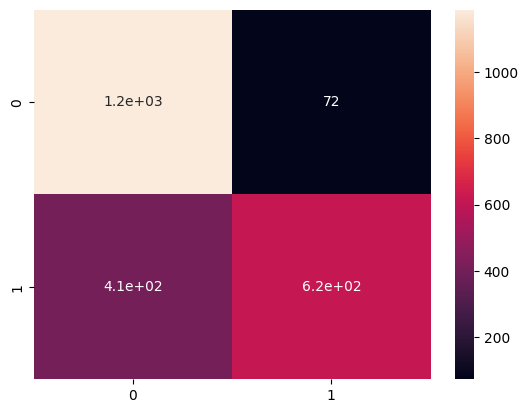

In [ ]:
baseline_results = print_evaluation_metrics(val_labels, baseline_preds)

.................Pred Pos.....Pred Neg

Actual Pos....TP.................FN

Actual Neg....FP.................TN

In [ ]:
# baseline_preds_1 = model_lr.predict(val_sentences)
# baseline_preds_2 = model_knn.predict(val_sentences)
# baseline_preds_3 = model_rf.predict(val_sentences)

In [ ]:
# print_evaluation_metrics(val_labels, baseline_preds_1)

In [ ]:
# print_evaluation_metrics(val_labels, baseline_preds_1)

In [ ]:
# print_evaluation_metrics(val_labels, baseline_preds_1)

In [ ]:
model_lr = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", LogisticRegression())
])

model_lr.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LogisticRegression())])

In [ ]:
# Evaluate our model
baseline_score_2 = model_lr.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score_2*100:.2f}%")

Our baseline model achieves an accuracy of: 80.08%


In [ ]:
model_knn = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", KNeighborsClassifier())
])

model_knn.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', KNeighborsClassifier())])

In [ ]:
# Evaluate our model
baseline_score_3 = model_knn.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score_3*100:.2f}%")

Our baseline model achieves an accuracy of: 77.85%


In [ ]:
model_rf = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("clf", RandomForestClassifier())
])

model_rf.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('clf', RandomForestClassifier())])

In [ ]:
baseline_score_4 = model_rf.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score_4*100:.2f}%")

Our baseline model achieves an accuracy of: 77.63%


In [ ]:
baseline_preds_1 = model_lr.predict(val_sentences)
baseline_preds_2 = model_knn.predict(val_sentences)
baseline_preds_3 = model_rf.predict(val_sentences)

Accuracy: 80.08%
Precision: 82.79%
Recall: 70.09%
F1 Score: 75.91%


{'accuracy': 0.8007880910683012,
 'precision': 0.8279445727482679,
 'recall': 0.7008797653958945,
 'F1 Score': 0.7591318157755426}

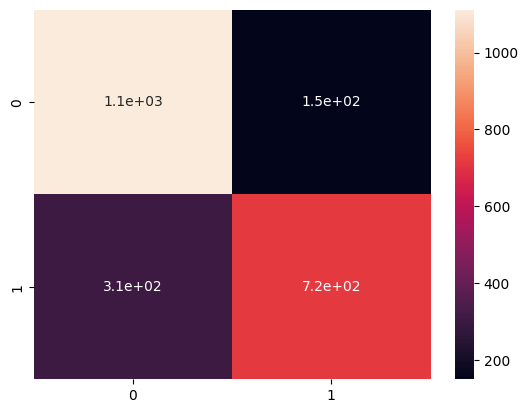

In [ ]:
print_evaluation_metrics(val_labels, baseline_preds_1)

Accuracy: 77.85%
Precision: 80.88%
Recall: 66.18%
F1 Score: 72.80%


{'accuracy': 0.7784588441330998,
 'precision': 0.8088410991636799,
 'recall': 0.6617790811339198,
 'F1 Score': 0.7279569892473118}

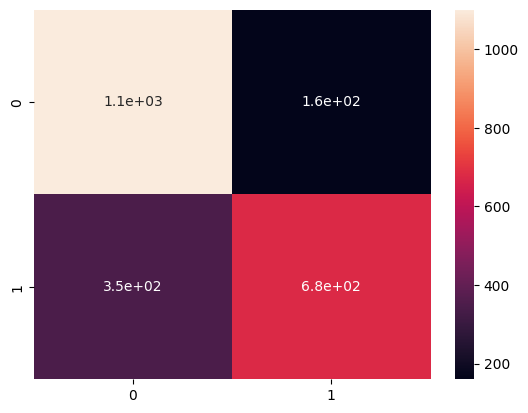

In [ ]:
print_evaluation_metrics(val_labels, baseline_preds_2)

Accuracy: 77.63%
Precision: 87.87%
Recall: 58.06%
F1 Score: 69.92%


{'accuracy': 0.7762697022767076,
 'precision': 0.878698224852071,
 'recall': 0.5806451612903226,
 'F1 Score': 0.6992348440258976}

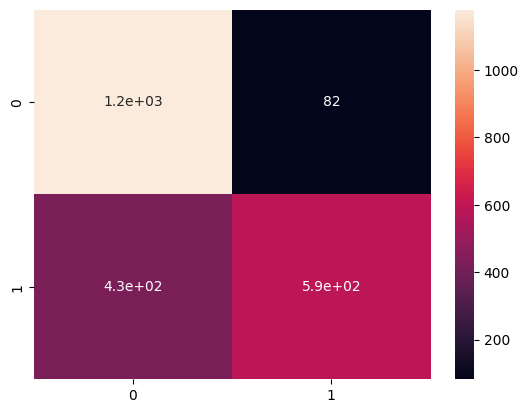

In [ ]:
print_evaluation_metrics(val_labels, baseline_preds_3)

In [ ]:
# Create 1-D convolutionsal layer to model sequences
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(64, 5, activation="relu")(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_DL = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile the model
model_DL.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_DL_his = model_DL.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.6380 - loss: 0.6430 - val_accuracy: 0.7785 - val_loss: 0.4767
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - accuracy: 0.8555 - loss: 0.3541 - val_accuracy: 0.7920 - val_loss: 0.4560
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9263 - loss: 0.2121 - val_accuracy: 0.7785 - val_loss: 0.5379
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9642 - loss: 0.1216 - val_accuracy: 0.7776 - val_loss: 0.6360
Epoch 5/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9714 - loss: 0.0865 - val_accuracy: 0.7697 - val_loss: 0.6753


In [ ]:
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(32, 3, activation="relu")(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_DL = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile the model
model_DL.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
model_DL_his = model_DL.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels))

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8609 - loss: 0.4534 - val_accuracy: 0.7693 - val_loss: 0.5435
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9599 - loss: 0.1356 - val_accuracy: 0.7631 - val_loss: 0.6476
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9764 - loss: 0.0840 - val_accuracy: 0.7618 - val_loss: 0.7458
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9792 - loss: 0.0626 - val_accuracy: 0.7653 - val_loss: 0.7964
Epoch 5/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.9821 - loss: 0.0523 - val_accuracy: 0.7666 - val_loss: 0.8514


In [ ]:
# inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
# x = text_vectorizer(inputs)
# x = embedding(x)
# x = tf.keras.layers.Conv1D(32, 3, activation="relu")(x)
# x = tf.keras.layers.GlobalMaxPool1D()(x)
# outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
# model_DL = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# # Compile the model
# model_DL.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#                 optimizer=tf.keras.optimizers.Adam(),
#                 metrics=["accuracy"])

# # Fit the model
# model_DL_his = model_DL.fit(train_sentences,
#                               train_labels,
#                               epochs=5,
#                               validation_data=(val_sentences, val_labels))

In [ ]:
import tensorflow as tf

# Input layer
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")

# Preprocessing layers
x = text_vectorizer(inputs)
x = embedding(x)

# LSTM layer (replacing Conv1D)
x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.LSTM(32, return_sequences=False)(x)

# Output layer
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Define the model
model_DL_LSTM = tf.keras.Model(inputs, outputs, name="model_LSTM")

# Compile the model
model_DL_LSTM.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                      metrics=["accuracy"])

# Fit the model
model_DL_LSTM_his = model_DL_LSTM.fit(train_sentences,
                                      train_labels,
                                      epochs=8,  # Increase a bit for LSTM training
                                      validation_data=(val_sentences, val_labels))

Epoch 1/8
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.8334 - loss: 0.3690 - val_accuracy: 0.7758 - val_loss: 0.6480
Epoch 2/8
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9644 - loss: 0.1062 - val_accuracy: 0.7544 - val_loss: 0.8516
Epoch 3/8
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.9677 - loss: 0.0915 - val_accuracy: 0.7754 - val_loss: 1.0428
Epoch 4/8
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.9788 - loss: 0.0486 - val_accuracy: 0.7535 - val_loss: 1.1755
Epoch 5/8
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.9793 - loss: 0.0556 - val_accuracy: 0.7706 - val_loss: 1.2768
Epoch 6/8
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9794 - loss: 0.0529 - val_accuracy: 0.7697 - val_loss: 1.3718
Epoch 7/8
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.9774 - loss: 0.0441 - val_accuracy: 0.7447 - val_loss: 1.2994
Epoch 8/8
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9828 - loss: 0.0342 - val_accuracy: 

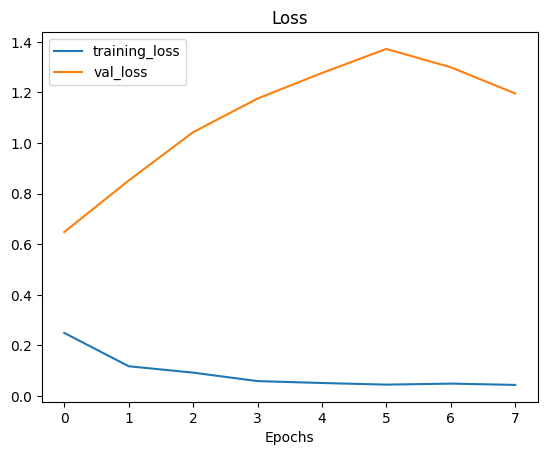

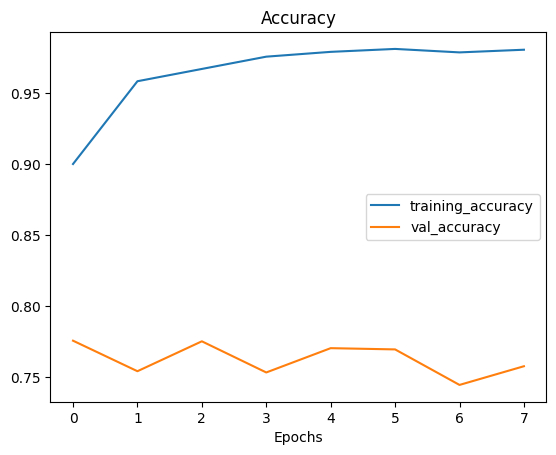

In [ ]:
plot_loss_curves(model_DL_LSTM_his)

In [ ]:
import tensorflow as tf

# Input
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")

# Text Vectorization and Embedding
x = text_vectorizer(inputs)
x = embedding(x)

# LSTM with improvements
x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32))(x)
x = tf.keras.layers.Dropout(0.5)(x)

# Output
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Model
model_DL_LSTM = tf.keras.Model(inputs, outputs, name="model_LSTM")

# Compile
model_DL_LSTM.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                      metrics=["accuracy"])

# EarlyStopping callback
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

# Train
model_DL_LSTM_his = model_DL_LSTM.fit(train_sentences,
                                      train_labels,
                                      epochs=20,
                                      validation_data=(val_sentences, val_labels),
                                      callbacks=[early_stop])


Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.5579 - loss: 0.6695 - val_accuracy: 0.6848 - val_loss: 0.5959
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.8600 - loss: 0.4000 - val_accuracy: 0.7763 - val_loss: 0.5356
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.9700 - loss: 0.1169 - val_accuracy: 0.7846 - val_loss: 0.6716
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.9819 - loss: 0.0678 - val_accuracy: 0.7693 - val_loss: 0.7334
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9820 - loss: 0.0556 - val_accuracy: 0.7588 - val_loss: 0.7954


In [ ]:
# Create 1-D convolutionsal layer to model sequences
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = tf.keras.layers.Conv1D(128, 5, activation="relu", padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, 5, activation="relu", padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(32, 5, activation="relu", padding="same")(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_DLL = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile the model
model_DLL.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                metrics=["accuracy"])

# Fit the model
model_DLL_his = model_DLL.fit(train_sentences,
                              train_labels,
                              epochs=15,
                              validation_data=(val_sentences, val_labels))

Epoch 1/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.9155 - loss: 0.1876 - val_accuracy: 0.7688 - val_loss: 0.5268
Epoch 2/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9831 - loss: 0.0419 - val_accuracy: 0.7518 - val_loss: 0.5482
Epoch 3/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.9848 - loss: 0.0353 - val_accuracy: 0.7701 - val_loss: 0.8917
Epoch 4/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9850 - loss: 0.0296 - val_accuracy: 0.7566 - val_loss: 1.3267
Epoch 5/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9853 - loss: 0.0276 - val_accuracy: 0.7644 - val_loss: 1.4770
Epoch 6/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.9849 - loss: 0.0284 - val_accuracy: 0.7688 - val_loss: 1.7361
Epoch 7/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.9885 - loss: 0.0234 - val_accuracy: 0.7434 - val_loss: 1.6280
Epoch 8/15
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9876 - loss: 0.0254 - val_accu

In [ ]:
# Create 1-D convolutionsal layer to model sequences
# inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
# x = text_vectorizer(inputs)
# x = embedding(x)
# x = tf.keras.layers.Conv1D(128, 5, activation="relu", padding="same")(x)
# x = tf.keras.layers.BatchNormalization()(x)
# x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)
# x = tf.keras.layers.Conv1D(64, 5, activation="relu")(x)
# x = tf.keras.layers.GlobalMaxPool1D()(x)
# outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
# model_DLL = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# # Compile the model
# model_DLL.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#                 optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
#                 metrics=["accuracy"])

# # Fit the model
# model_DLL_his = model_DLL.fit(train_sentences,
#                               train_labels,
#                               epochs=15,
#                               validation_data=(val_sentences, val_labels))

In [ ]:
model_rf_2 = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=2000,   # Limit vocabulary size
        ngram_range=(1, 2),  # Use unigrams and bigrams
        stop_words='english' # Remove common English stopwords
    )),
    ("clf", RandomForestClassifier(
        n_estimators=200,    # More trees
        max_depth=25,        # Limit tree depth to prevent overfitting
        min_samples_split=5, # Minimum samples needed to split a node
        min_samples_leaf=2,  # Minimum samples needed at a leaf node
        max_features='sqrt', # Number of features to consider when looking for best split
        random_state=42      # For reproducibility
    ))
])

model_rf_2.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=2000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf',
                 RandomForestClassifier(max_depth=25, min_samples_leaf=2,
                                        min_samples_split=5, n_estimators=200,
                                        random_state=42))])

Accuracy: 70.88%
Precision: 94.31%
Recall: 37.24%
F1 Score: 53.40%


{'accuracy': 0.7088441330998249,
 'precision': 0.943069306930693,
 'recall': 0.3724340175953079,
 'F1 Score': 0.5339873861247372}

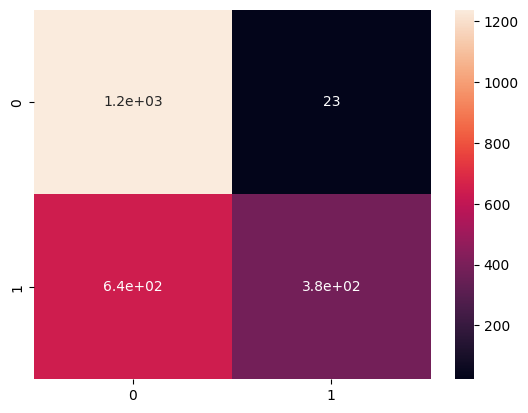

In [ ]:
baseline_preds_4 = model_rf_2.predict(val_sentences)
print_evaluation_metrics(val_labels, baseline_preds_4)

In [ ]:
# dl_score = model_DL.evaluate(val_sentences, val_labels)
dl_score = tf.squeeze(tf.round(model_DL.predict(val_sentences)))

72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


Accuracy: 75.09%
Precision: 72.98%
Recall: 70.48%
F1 Score: 71.71%


{'accuracy': 0.750875656742557,
 'precision': 0.729757085020243,
 'recall': 0.7047898338220919,
 'F1 Score': 0.7170561909497762}

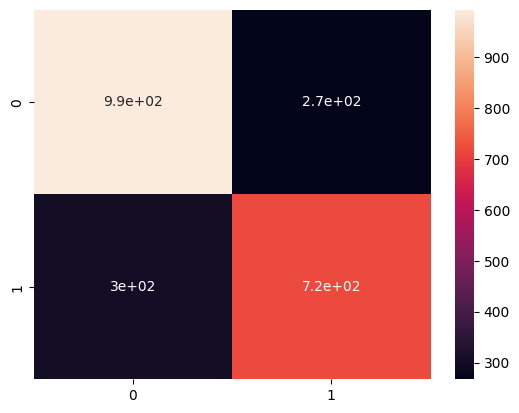

In [ ]:
print_evaluation_metrics(val_labels, np.array(dl_score))

In [ ]:
# Create 1-D convolutional model
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)

# First Conv1D block
x = tf.keras.layers.Conv1D(128, 5, activation="relu", padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)

# Second Conv1D block
x = tf.keras.layers.Conv1D(64, 5, activation="relu", padding="same")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.MaxPooling1D(pool_size=2)(x)

# Third Conv1D block (optional for deeper model)
x = tf.keras.layers.Conv1D(32, 3, activation="relu", padding="same")(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

# Dense layers
x = tf.keras.layers.Dense(64, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)  # Dropout for regularization

# Output layer
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# Define the model
model_DL_2 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D_Improved")

# Compile the model
model_DL_2.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=["accuracy"]
)

# Fit the model
model_DL_his_2 = model_DL_2.fit(
    train_sentences,
    train_labels,
    epochs=10,  # you can increase epochs since model is deeper
    validation_data=(val_sentences, val_labels)
)


Epoch 1/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.9296 - loss: 0.1646 - val_accuracy: 0.7123 - val_loss: 0.5534
Epoch 2/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9794 - loss: 0.0474 - val_accuracy: 0.7574 - val_loss: 0.7143
Epoch 3/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9838 - loss: 0.0326 - val_accuracy: 0.7539 - val_loss: 1.4495
Epoch 4/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9779 - loss: 0.0382 - val_accuracy: 0.7649 - val_loss: 2.1956
Epoch 5/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9798 - loss: 0.0368 - val_accuracy: 0.7588 - val_loss: 2.2460
Epoch 6/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9816 - loss: 0.0351 - val_accuracy: 0.7675 - val_loss: 2.3417
Epoch 7/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9814 - loss: 0.0428 - val_accuracy: 0.7592 - val_loss: 2.2248
Epoch 8/10
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9848 - loss: 0.0302 - val_accu

In [ ]:
sentences = ["oh no i lost my car", "i am very happy", "there is mole in the hole", "I study in dtu"]
test = text_vectorizer(sentences)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
v = TfidfVectorizer(use_idf=False,
                    norm=None)
vv = v.fit_transform(sentences)

In [ ]:
# model_DL_2.predict(vv)

In [ ]:
# print_evaluation_metrics(val_labels,)

In [ ]:
from scipy.stats import chi2, rankdata
import numpy as np
def friedman_test(data):
    data = np.array(data)
    n, k = data.shape
    ranks = np.array([rankdata(-row, method='average') for row in data])
    rank_sums = ranks.sum(axis=0)
    chi_square_stat = (((12) / (n * k * (k + 1))) * np.sum(rank_sums ** 2)) - 3 * n * (k + 1)
    degrees_of_freedom = k - 1
    p_value = 1 - chi2.cdf(chi_square_stat, degrees_of_freedom)
    return chi_square_stat, p_value, degrees_of_freedom
data = [
    [0.919, 0.919, 0.919,0.912],
    [0.872, 0.778, 0.840,0.675],
    [0.900, 0.900, 0.766,0.876]
]
chi_square_stat, p_value, degrees_of_freedom = friedman_test(data)
print(f"Friedman Chi-Square Statistic: {chi_square_stat}")
print(f"p-value: {p_value}")
print(f"Degrees of Freedom: {degrees_of_freedom}")
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis")
else:
    print("Fail to reject the null hypothesis.")


Friedman Chi-Square Statistic: 4.5
p-value: 0.21229028736013267
Degrees of Freedom: 3
Fail to reject the null hypothesis.


In [ ]:
import numpy as np
from scipy.stats import norm
def wilcoxon_signed_rank_test(x, y, alpha=0.05):
    differences = np.array(x) - np.array(y)
    non_zero_differences = differences[differences != 0]
    abs_differences = np.abs(non_zero_differences)
    ranks = np.argsort(np.argsort(abs_differences)) + 1
    positive_ranks = sum(ranks[non_zero_differences > 0])
    negative_ranks = sum(ranks[non_zero_differences < 0])
    Q = min(positive_ranks, negative_ranks)
    n = len(non_zero_differences)
    W1 = n * (n + 1) / 4
    W2 = np.sqrt(n * (n + 1) * (2 * n + 1) / 24)
    z = (Q - W1) / W2
    p_value = 2 * norm.cdf(z) if z < 0 else 2 * (1 - norm.cdf(z))
    return z, p_value
group1 = [0.919,0.872, 0.900] #rf
group2 = [ 0.919, 0.778,0.900] #gbc
z, p_value = wilcoxon_signed_rank_test(group1, group2)
print(f" Z Statistic for Wilcoxon Signed Rank test: {z}")
print(f"p-value: {p_value}")
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis ")
else:
    print("Fail to reject the null hypothesis ")


 Z Statistic for Wilcoxon Signed Rank test: -1.0
p-value: 0.31731050786291415
Fail to reject the null hypothesis 


In [ ]:
import numpy as np
from scipy.stats import f
def anova(data):
    k = data.shape[1]
    n_total = data.size
    grand_mean = np.mean(data)
    group_means = np.mean(data, axis=0)
    n_per_group = data.shape[0]
    ssb = n_per_group * np.sum((group_means - grand_mean) ** 2)
    ssw = np.sum((data - group_means) ** 2, axis=0).sum()
    dfb = k - 1
    dfw = n_total - k
    msb = ssb / dfb
    msw = ssw / dfw
    f_statistic = msb / msw
    p_value = 1 - f.cdf(f_statistic, dfb, dfw)
    return f_statistic, p_value
accuracy_scores = np.array([
    [0.919, 0.919, 0.919,0.912],
    [0.872, 0.778, 0.840,0.675],
    [0.900, 0.900, 0.766,0.876]
] )
f_stat, p_val = anova(accuracy_scores)
print(f"F-statistic: {f_stat}")
print(f"p-value: {p_val}")
alpha = 0.05
if p_val < alpha:
    print("Reject the null hypothesis ")
else:
    print("Fail to reject the null hypothesis")


F-statistic: 0.4485086000435429
p-value: 0.7252014514632028
Fail to reject the null hypothesis


In [ ]:
# Friedman test then Nemenyi test-
import numpy as np
from scipy.stats import norm
from scipy.stats import rankdata, chi2
alpha = 0.05
def friedman_test(data):
    data = np.array(data)
    n, k = data.shape
    ranks = np.array([rankdata(-row, method='average') for row in data])
    rank_sums = ranks.sum(axis=0)
    average_ranks = rank_sums/n
    chi_square_stat = (((12) / (n * k * (k + 1))) * np.sum(rank_sums ** 2)) - 3 * n * (k + 1)
    degrees_of_freedom = k - 1
    p_value = 1 - chi2.cdf(chi_square_stat, degrees_of_freedom)
    return chi_square_stat, p_value, degrees_of_freedom,average_ranks
def nemenyi_test(avg_ranks, number_of_observations , alpha):
    k = len(avg_ranks)
    q_alpha = 2.569032073
    CD = q_alpha * np.sqrt((k * (k + 1)) / (6 * number_of_observations))
    differences = []
    for i in range(k):
        for j in range(i + 1, k):
            diff = abs(avg_ranks[i] - avg_ranks[j])
            differences.append((i, j, diff))
    print(f"Critical Difference (CD): {CD:.4f}")
    print("\nPairwise Comparisons:")
    for i, j, diff in differences:
        if diff > CD:
          print(f"Rank difference between technique {i+1} and technique {j+1} is significant: {diff:.4f} >{CD}")
        else:
          print(f"Rank difference between technique {i+1} and technique {j+1} is not significant: {diff:.4f} < {CD}")
data = [
    [0.919, 0.919, 0.919,0.912],
    [0.872, 0.778, 0.840,0.675],
    [0.900, 0.900, 0.766,0.876]
]
chi_square_stat, p_value, degrees_of_freedom,average_ranks = friedman_test(data)
if p_value < alpha:
    print("As per the friedman we  reject the null hypothesis and there is a significant difference in performance of the algorithms ")
else:
    print("Fail to reject the null hypothesis there is no significant difference in performance of the algorithms")
number_of_observations = 3
print(average_ranks)
nemenyi_test(average_ranks, number_of_observations, alpha)

Fail to reject the null hypothesis there is no significant difference in performance of the algorithms
[1.5        2.16666667 2.66666667 3.66666667]
Critical Difference (CD): 2.7080

Pairwise Comparisons:
Rank difference between technique 1 and technique 2 is not significant: 0.6667 < 2.707997577567987
Rank difference between technique 1 and technique 3 is not significant: 1.1667 < 2.707997577567987
Rank difference between technique 1 and technique 4 is not significant: 2.1667 < 2.707997577567987
Rank difference between technique 2 and technique 3 is not significant: 0.5000 < 2.707997577567987
Rank difference between technique 2 and technique 4 is not significant: 1.5000 < 2.707997577567987
Rank difference between technique 3 and technique 4 is not significant: 1.0000 < 2.707997577567987


In [ ]:
# max_vocab_length = 10000
# max_length = 15

# text_vectorizer = tf.keras.layers.TextVectorization(max_tokens=max_vocab_length,
#                                                   output_mode="int",
#                                                   output_sequence_length=max_length)

# embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length,
#                                       output_dim=128,
#                                       input_length=max_length)

# import tensorflow as tf

# # Input layer
# inputs = tf.keras.layers.Input(shape=(1,), dtype="string")

# # Preprocessing layers
# x = text_vectorizer(inputs)
# x = embedding(x)

# # LSTM layer (replacing Conv1D)
# x = tf.keras.layers.LSTM(64, return_sequences=False)(x)

# # Output layer
# outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# # Define the model
# model_DL_LSTM = tf.keras.Model(inputs, outputs, name="model_LSTM")

# # Compile the model
# model_DL_LSTM.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#                       optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#                       metrics=["accuracy"])

# # Fit the model
# model_DL_LSTM_his = model_DL_LSTM.fit(train_sentences,
#                                       train_labels,
#                                       epochs=8,  # Increase a bit for LSTM training
#                                       validation_data=(val_sentences, val_labels))

In [ ]:
# max_vocab_length = 5000  # if your dataset is not huge
# max_length = 30          # increase to 30

# text_vectorizer = tf.keras.layers.TextVectorization(
#     max_tokens=max_vocab_length,
#     output_mode="int",
#     output_sequence_length=max_length
# )

# embedding = tf.keras.layers.Embedding(
#     input_dim=max_vocab_length,
#     output_dim=128,  # or 256 if you want to try
#     input_length=max_length
# )

# # Input layer
# inputs = tf.keras.layers.Input(shape=(1,), dtype="string")

# # Preprocessing layers
# x = text_vectorizer(inputs)
# x = embedding(x)

# # LSTM layer (replacing Conv1D)
# x = tf.keras.layers.LSTM(64, return_sequences=False)(x)

# # Output layer
# outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)

# # Define the model
# model_DL_LSTM = tf.keras.Model(inputs, outputs, name="model_LSTM")

# # Compile the model
# model_DL_LSTM.compile(loss=tf.keras.losses.BinaryCrossentropy(),
#                       optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
#                       metrics=["accuracy"])

# # Fit the model
# model_DL_LSTM_his = model_DL_LSTM.fit(train_sentences,
#                                       train_labels,
#                                       epochs=8,  # Increase a bit for LSTM training
#                                       validation_data=(val_sentences, val_labels))

Some sample modelling for further improvements


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Dense
from tensorflow.keras.models import Sequential
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

nltk.download('punkt')  # only once


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import nltk

# Download commonly used datasets and models
nltk.download('punkt')             # Tokenizers
nltk.download('stopwords')         # Stopwords list
nltk.download('wordnet')           # WordNet (for lemmatization)
nltk.download('omw-1.4')           # WordNet synonyms
nltk.download('averaged_perceptron_tagger')  # POS tagging
nltk.download('maxent_ne_chunker') # Named Entity Chunker
nltk.download('words')             # Common English words list
nltk.download('treebank')          # POS tagged corpus
nltk.download('brown')             # Brown corpus
nltk.download('tagsets')           # Tagset reference
nltk.download('vader_lexicon')     # Sentiment analysis


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package treebank to /root/nltk_data...
[nltk_data]   Unzipping corpora/treebank.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package ta

True

In [ ]:
# Example data (replace with your own NumPy arrays)
sentences = np.array([
    "I love coding in Python!",
    "Machine learning is amazing.",
    "Natural language processing is fun."
])
labels = np.array([1, 1, 0])  # Binary classification


In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
stemmer = PorterStemmer()

def stem_sentence(sentence):
    tokens = word_tokenize(sentence.lower())
    stemmed = [stemmer.stem(word) for word in tokens]
    return " ".join(stemmed)

stemmed_sentences = np.array([stem_sentence(sent) for sent in sentences])


In [ ]:
max_tokens = 1000
output_sequence_length = 20

vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=output_sequence_length)
vectorizer.adapt(stemmed_sentences)


In [ ]:
embedding_dim = 16

model = Sequential([
    vectorizer,
    Embedding(input_dim=max_tokens, output_dim=embedding_dim),
    GlobalAveragePooling1D(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # For binary classification
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
# model.fit(stemmed_sentences, labels, epochs=10)

ValueError: Invalid dtype: str960

In [ ]:
stemmed_sentences = tf.convert_to_tensor(stemmed_sentences, dtype=tf.string)
model.fit(stemmed_sentences, labels, epochs=10)